# _***Predicción de enfermedades cardiacas***_

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

## _***1: DATA WRANGLING.***_

+ Mediante el siguiente comando se obtiene el conjunto de datos por medio del método `read_csv` de la librería `Pandas`

In [2]:
url = "https://raw.githubusercontent.com/GabrielCastro1221/csv_dataScience/main/heart1.csv"
df = pd.read_csv(url)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


+ Con el método `info` de la librería `Pandas` se muestra la información detallada del conjunto de datos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Una vez se analiza la información que se obtiene con el método `info` de la librería `pandas`, se puede deducir lo siguiente:

+ Número de registros 1025.

+ Número de campos 14.

+ En el conjunto de datos solo hay un campo de tipo float (oldpeak), el resto de campos son de tipo entero.

+ el conjunto de datos no contiene valores nulos.

_***NOTA:***_ Según los tipos de datos y las explicaciones de características que obtuvimos anteriormente, podemos ver que 9 columnas (sex, cp, fbs, restecg, exang, pendiente, ca, thal y target) son de tipo de dato numérico. Estas características deben convertirse al tipo de datos de cadena `Object` para poder hacer un análisis e interpretación adecuados.

Para transformar el tipo de dato se siguen los siguientes pasos:

+ se crea una variable a la cual se le asignaran los campos del conjunto de datos a los cuales se les aplicara la transformación de datos, a esta variable se le asigna el nombre de `continous_features`.

+ se crea una segunda variable la cual genera una lista que contendrá los nombres de los campos del conjunto de datos, esta variable contiene un ciclo for el cual iterara cada uno de los campos y solo transformara los campos asignados a la variable `continous_feature`

+ por último se ejecuta el método `astype("object")` para convertir los campos de datos que se transformaran en tipo `Object`

In [4]:
continuous_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
features_to_convert = [
    feature for feature in df.columns if feature not in continuous_features
]
df[features_to_convert] = df[features_to_convert].astype("object")
df.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target       object
dtype: object

Con el método `describe().T` de la librería pandas se muestran los resultados estadísticos de los datos numéricos del conjunto de datos.

_***NOTA:***_ el metodo describe con el `.T` lo que hace es cambiar la orientación de la tabla. A mi parecer se analizan mejor los datos de esta manera.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


De acuerdo a la información proporcionada por el método `describe` de la librería `pandas` se puede deducir lo siguiente:

+ _***Edad***_ `age:` La edad promedio de los pacientes es de aproximadamente 54 años, siendo el más joven 29 y el mayor 77 años.

+  _***Presión arterial en reposo***_ `trestbps:` La presión arterial promedio en reposo es de aproximadamente 131,6mm/Hg, con un rango de 94 a 200 mm/Hg.

+ _***Colesterol sérico***_ `chol:` El nivel promedio de colesterol es de aproximadamente 246 mg/dl, con un mínimo de 126 y un máximo de 564 mg/dl.

+ _***Frecuencia cardíaca máxima alcanzada***_ `Thalach:` La frecuencia cardíaca máxima media alcanzada ronda los 149,1, con un rango de 71 a 202.

+ _***Depresión del ST inducida por el ejercicio***_ `oldpeak:` La depresión ST promedio inducida por el ejercicio en relación con el reposo es aproximadamente 1,07, con valores que oscilan entre 0 y 6,2.

A continuación se usará el método `describe(include="object").T` de `pandas`, este método muestra los resultados estadísticos de los datos categóricos del conjunto de datos.

In [6]:
df.describe(include="object").T

,count,unique,top,freq
sex,1025,2,1,713
cp,1025,4,0,497
fbs,1025,2,0,872
restecg,1025,3,1,513
exang,1025,2,0,680
slope,1025,3,1,482
ca,1025,5,0,578
thal,1025,4,2,544
target,1025,2,1,526


De acuerdo con la información proporcionada por el método que se ejecutó en el paso anterior, se puede deducir lo siguiente:

+ _***Sexo***_ `sex:` Hay dos valores únicos, la categoría que predomina según el análisis es el sexo femenino a la que corresponde el valor 1, apareciendo con una frecuencia de 713 veces en el conjunto de datos.

+ _***Tipo de dolor torácico***_ `cp:` Hay cuatro categorías unicas. El tipo más común es "0" (que indica que es angina típica) y aparece con una frecuencia 497 veces en el conjunto de datos.

+ _***Azúcar en la sangre en ayunas***_ `fbs:` Hay dos categorías, y la más frecuente es "0" (que indica azúcar en sangre en ayunas inferior a 120 mg/dl), que aparece 872 veces en el conjunto de datos.

+ _***Resultados electrocardiográficos en reposo***_ `restecg:` Hay tres categorías únicas. El resultado más común es "1" (que indica tener anomalía en la onda ST) y aparece con una frecuencia de 513 veces en el conjunto de datos.

+ _***Angina inducida por el ejercicio***_ `exang:` Hay dos categorías únicas. El valor más frecuente es "0" (que indica que no hay angina inducida por el ejercicio), que apaceré 680 veces en el conjunto de datos.

+ _***Pendiente del segmento ST del ejercicio máximo***_ `slope:` Hay tres categorías únicas. El tipo de pendiente más frecuente es el "1" (que indica pendiente plana), que se presenta con una frecuencia de 482 veces en el conjunto de datos.

+ _***Número de vasos principales coloreados mediante fluoroscopia***_ `ca:` Hay cinco categorías únicas para el número de vasos principales coloreados mediante fluoroscopia, siendo "0" el más frecuente y aparece con una frecuencia de 578 veces en el conjunto de datos.

+  _***Resultado de la prueba de estrés con talio***_  `thal:` Hay cuatro categorías únicas disponibles. El tipo más común es el "2" (que indica un defecto reversible), y aparece con una frecuencia de 544 veces en el conjunto de datos.

+ _***Presencia de enfermedades cardiacas***_ `target:` hay dos categorias únicas indican la presencia o ausencia de enfermedad cardíaca. El valor "1" (que indica la presencia de enfermedades cardíacas) es el más frecuente, y aparece con una frecuencia de 526 veces en el conjunto de datos.

## _***2. EXPLORATORY DATA ANALYSIS (EDA)***_.

### _***2.1. Análisis univariado***_

Al emplear esta técnica de visualización, se comprenderán mejor las características individuales de cada característica del conjunto de datos.

#### _***Datos continuos***_

Se emplearán visualizaciones de tipo `histograma` para obtener información sobre la distribución de cada característica. Esto nos permite comprender la tendencia central, la extensión y la forma de la distribución del conjunto de datos.

Para visualizar los histogramas se siguen los siguientes pasos:

+ Se crea una variable la cual contendrá las características continuas de los datos.

+ Se implementa un bucle for el cual iterara las variables continuas del conjunto de datos y trazara los caracteres en los respectivos histogramas.

+ Se genera el gráfico que recibe los datos de la serie `df_continuos` los cuales se trazan en el eje X 

+ Se Asignan los labels que llevara cada uno de los ejes y sus respectivos estilos de visualización

+ Se crea un cuadro de texto en el gráfico del histograma, mostrando la media y la desviación estándar de los datos.

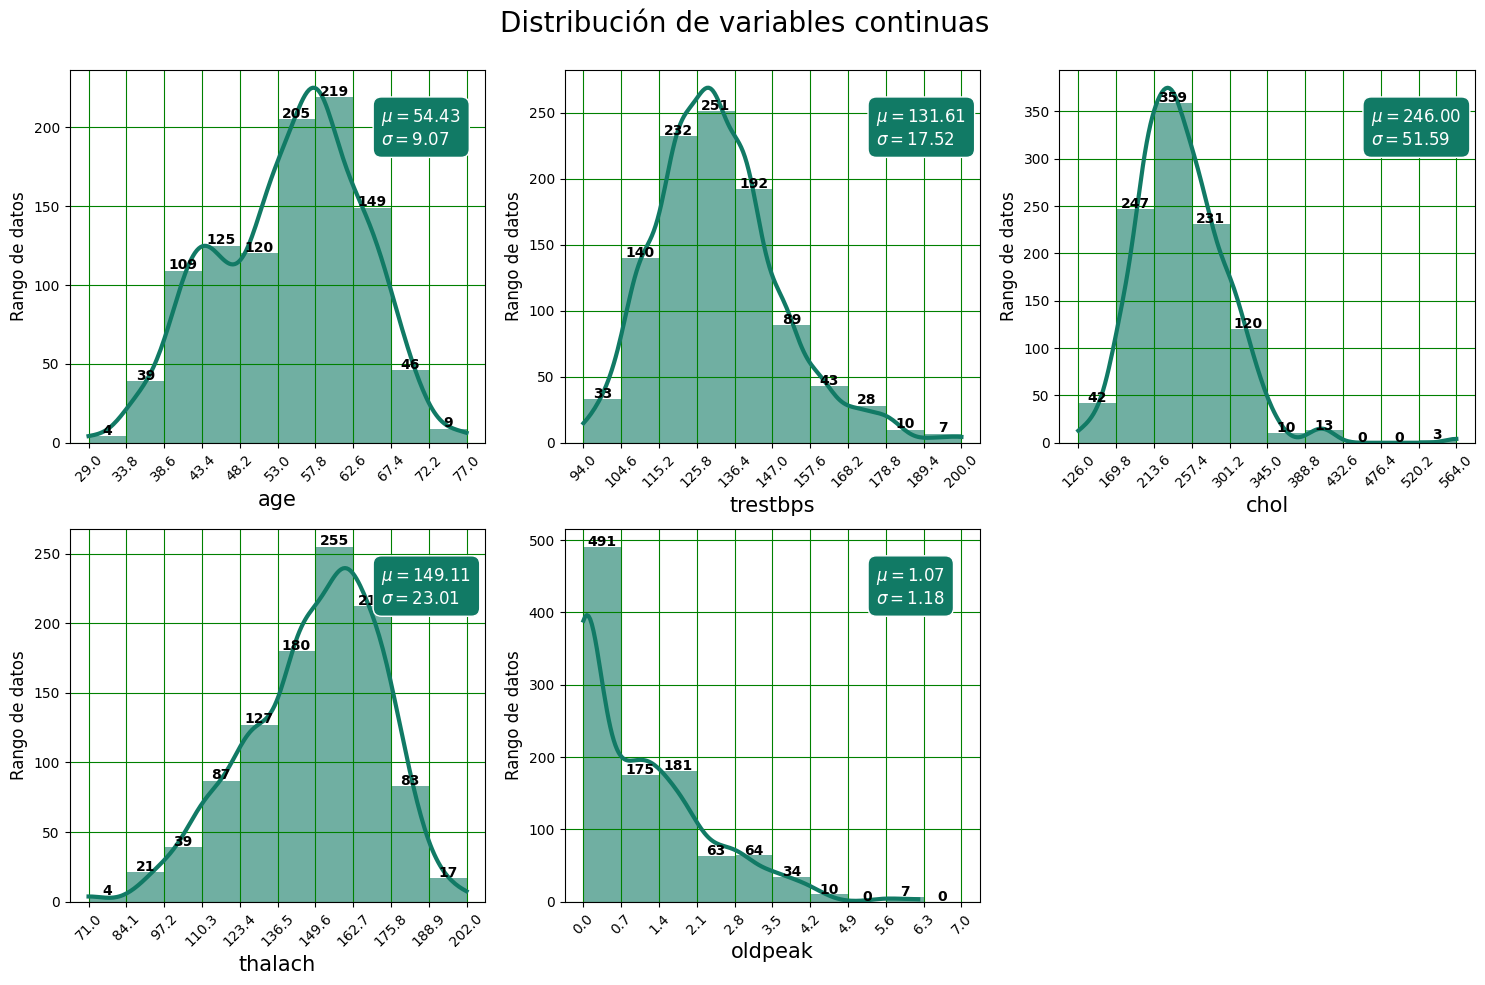

In [7]:
df_continuous = df[continuous_features]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(
        df_continuous[col],
        range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())),
    )

    graph = sns.histplot(
        data=df_continuous,
        x=col,
        bins=bin_edges,
        kde=True,
        ax=ax[x, y],
        edgecolor="none",
        color="#117A65",
        alpha=0.6,
        line_kws={"lw": 3},
    )

    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel("Rango de datos", fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color="Green")

    for j, p in enumerate(graph.patches):
        ax[x, y].annotate(
            "{}".format(p.get_height()),
            (p.get_x() + p.get_width() / 2, p.get_height() + 1),
            ha="center",
            fontsize=10,
            fontweight="bold",
        )

    textstr = "\n".join(
        (
            r"$\mu=%.2f$" % df_continuous[col].mean(),
            r"$\sigma=%.2f$" % df_continuous[col].std(),
        )
    )

    ax[x, y].text(
        0.75,
        0.9,
        textstr,
        transform=ax[x, y].transAxes,
        fontsize=12,
        verticalalignment="top",
        color="white",
        bbox=dict(boxstyle="round", facecolor="#117A65", edgecolor="white", pad=0.5),
    )

ax[1, 2].axis("off")
plt.suptitle("Distribución de variables continuas", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

+ _***Edad***_ `AGE:` 
    + la distribución es algo uniforme, pero hay un pico alrededor de los 50 años. 
    + La edad media es de aproximadamente 54,43 años 
    + La desviación estándar es de 9,07 años.

+ _***Presión arterial en reposo***_ `trestbps:` 
    + La presión arterial en reposo para la mayoría de las personas se concentra alrededor de 120-140 mm/Hg.
    + La media es de aproximadamente 131,61 mm/Hg
    + La desviación estándar es de 17,52 mm/Hg.

+ _***Colesterol sérico***_ `chol:` 
    + la mayoría de las personas tienen niveles de colesterol entre 200 y 300 mg/dl. 
    + El nivel medio de colesterol ronda los 246 mg/dl.
    + La desviación estándar es de 51,59 mg/dl.

+ _***Frecuencia cardíaca máxima alcanzada***_ `thalach:` 
    + la mayoría de las personas alcanzan una frecuencia cardíaca entre 140 y 170 lpm durante una prueba de esfuerzo.
    + La frecuencia cardíaca media alcanzada es de aproximadamente 149,11 bpm
    + La desviación estándar es de 23,01 bpm.

+ _***Depresión del ST inducida por el ejercicio***_ `oldpeak:` 
    + la mayoría de los valores se concentran hacia 0, lo que indica que muchos individuos no experimentaron una depresión del ST significativa durante el ejercicio. 
    + El valor medio de depresión del ST es 1,07.
    + La desviación estándar es de 1,18.

Al revisar los histogramas en los cuales se visualizan las características continuas y las comparaciones de las descripciones de las características proporcionadas, todo parece consistente y dentro de los rangos esperados. No parece haber ningún ruido perceptible ni valores improbables entre las variables continuas.

### _***Datos categóricos***_

Para visualizar los datos categóricos se utilizan `gráficos de barras` y asi poder visualizar la frecuencia de cada categoría. Esto proporciona una representación clara de la prominencia de cada categoría dentro de la característica respectiva.

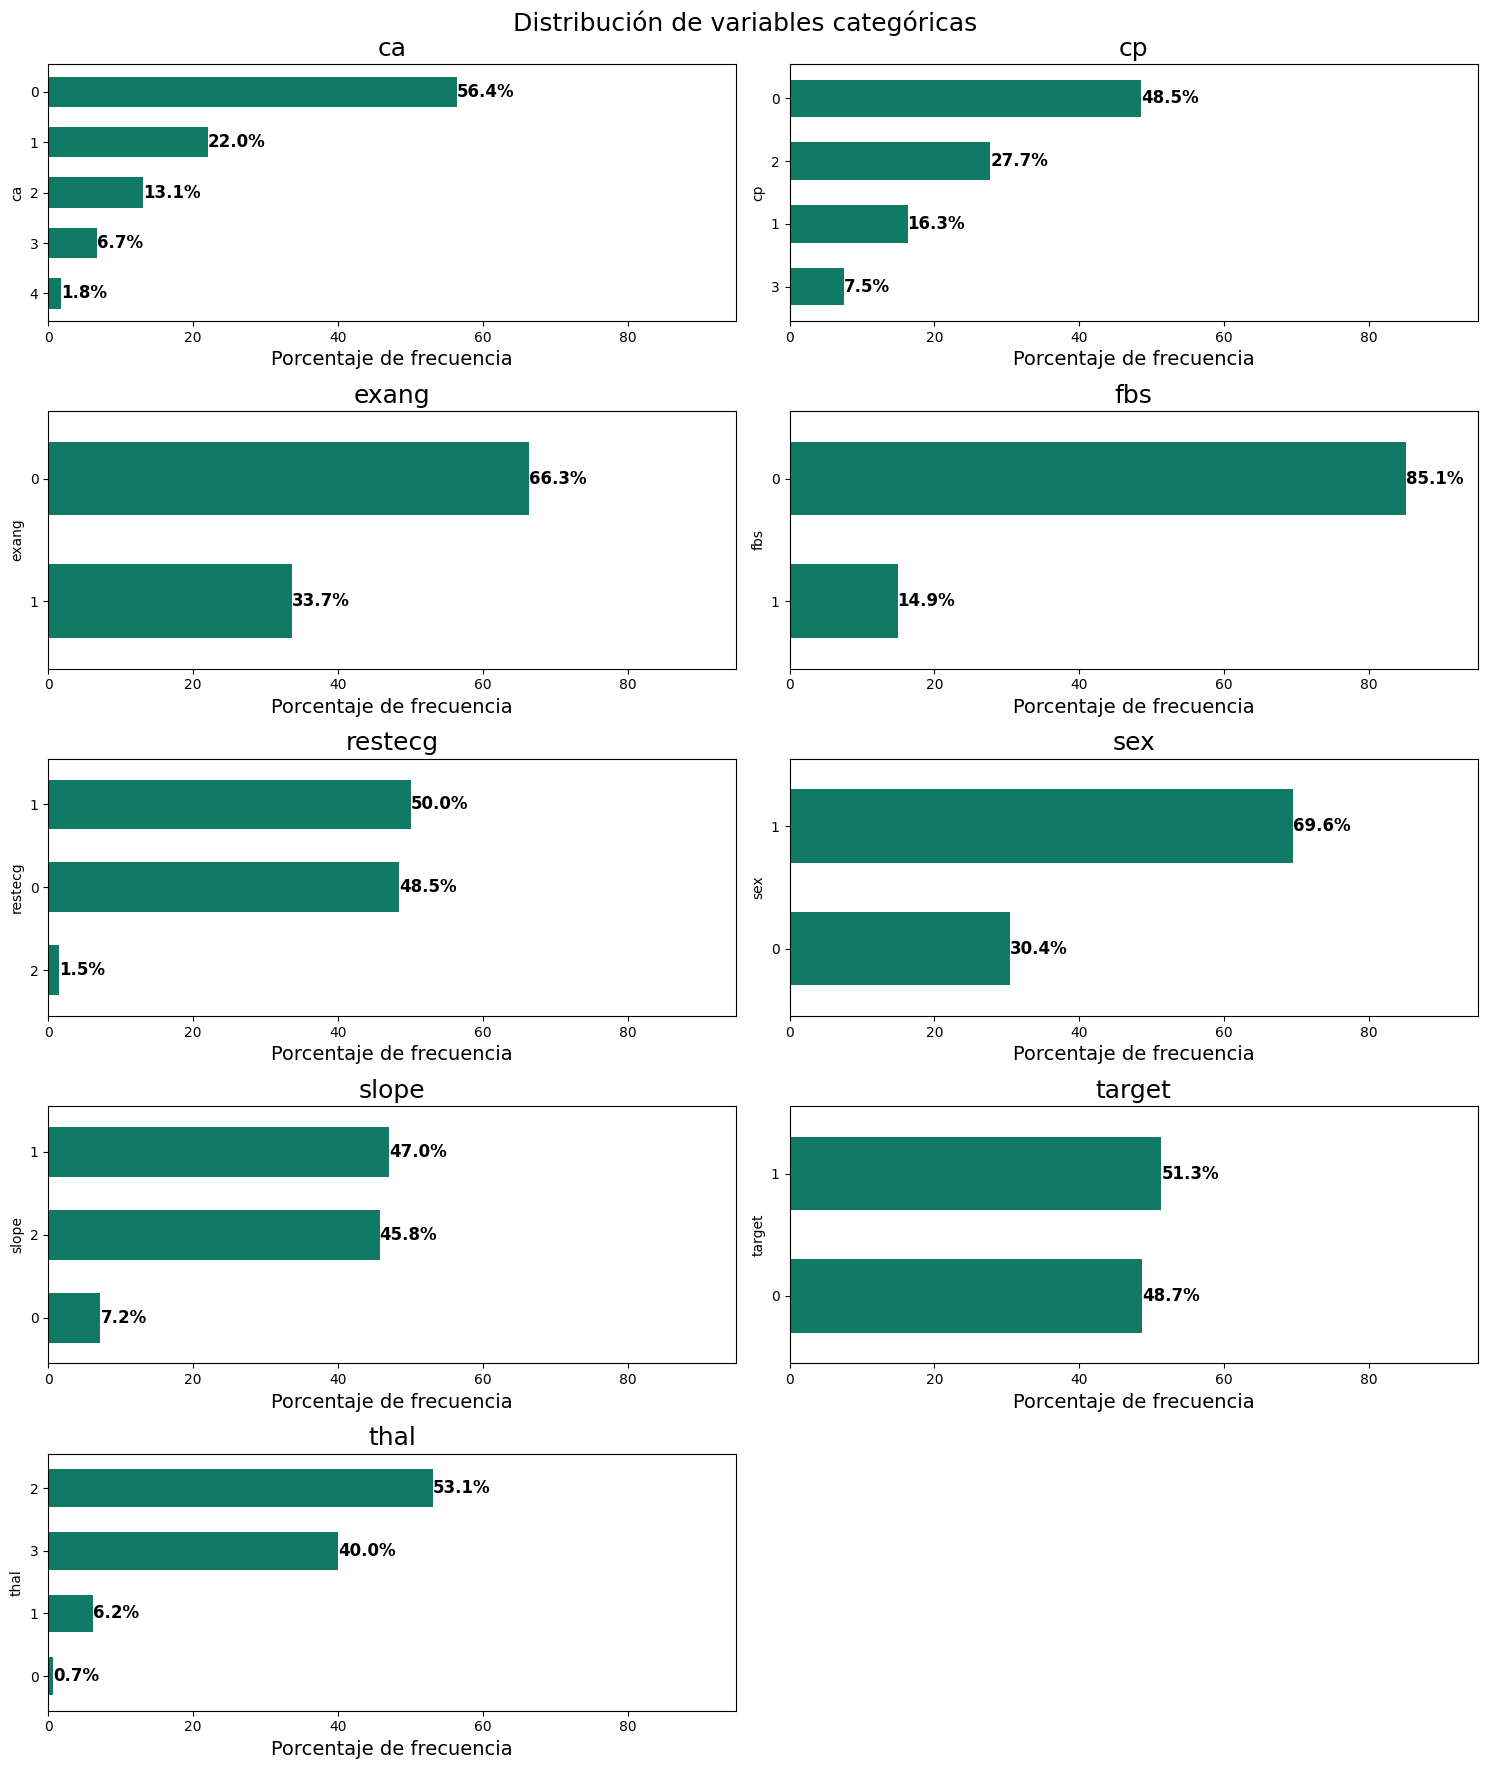

In [8]:
categorical_features = df.columns.difference(continuous_features)
df_categorical = df[categorical_features]
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

for i, col in enumerate(categorical_features):
    row = i // 2
    col_idx = i % 2

    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()
    value_counts.plot(kind="barh", ax=ax[row, col_idx], width=0.6, color="#117A65")

    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(
            value,
            index,
            str(round(value, 1)) + "%",
            fontsize=12,
            weight="semibold",
            va="center",
        )
        ax[row, col_idx].set_xlim([0, 95])
        ax[row, col_idx].set_xlabel("Porcentaje de frecuencia", fontsize=14)
        ax[row, col_idx].set_title(f"{col}", fontsize=18)

ax[4, 1].axis("off")
plt.suptitle("Distribución de variables categóricas", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

+ _***sexo***_: 
    `sex`: el conjunto de datos es predominantemente femenino y constituye una mayoría significativa.

+ _***Tipo de dolor torácico***_: 
    `cp`: el conjunto de datos muestra diversos tipos de dolor torácico entre los pacientes. El tipo 0 (angina típica) parece ser el más frecuente, pero a partir de los gráficos de barras se puede inferir una distribución exacta entre los tipos.

+ _***Azúcar en sangre en ayunas***_: 
    `fbs`: una mayoría significativa de los pacientes tienen su nivel de azúcar en sangre en ayunas por debajo de 120 mg/dl, lo que indica que el nivel alto de azúcar en sangre no es una condición común en este conjunto de datos.

+ _***Resultados electrocardiográficos en reposo***_: 
    `restecg`: Los resultados muestran resultados electrocardiográficos en reposo variados, siendo sinedo 1 (Tener anomalía de la onda ST-T) el mas frecuente por una minima diferencia. 

+ _***Angina inducida por el ejercicio***_:
    `exang`: la mayoría de los pacientes no experimentan angina inducida por el ejercicio, lo que sugiere que podría no ser un síntoma común entre los pacientes de este conjunto de datos.

+ _***Pendiente del segmento ST del ejercicio máximo***_:
    `slope`: el conjunto de datos muestra diferentes pendientes del segmento ST del ejercicio máximo. siendo 1 (Pendiente Plana) el mas frecuente.

+ _***Número de vasos principales coloreados mediante fluoroscopia***_:
    `ca`: la mayoría de los pacientes tienen menos vasos principales coloreados mediante fluoroscopia, siendo 0 el más frecuente.

+ _***Resultado de la prueba de estrés con talio***_:
    `thal`: el conjunto de datos muestra una variedad de resultados de las pruebas de estrés con talio. siendo 1 (Defecto solucionado) el mas frecuente.

+ _***Presencia de enfermedades cardíacas***_:
    `target`: el conjunto de datos está casi equilibrado en términos de presencia de enfermedades cardíacas: alrededor del 54,5 % las padece y el 45,5 % no las padece.

### _***2.2. Analisis bivariado.***_

A través de esta técnica de visualización, obtendremos una comprensión más profunda de la relación entre las características individuales y el objetivo, revelando posibles predictores de enfermedades cardíacas.

#### _***Datos continuos***_

Se utilizaran gráficos de barras para mostrar el valor promedio de cada característica para los diferentes campos categoricos, y gráficos de KDE para comprender la distribución de cada característica entre los campos categoricos. Esto ayuda a evaluar cómo varía cada característica entre los dos resultados objetivo.

Se graficara cada característica continua frente al objetivo usando dos tipos de gráficos.

+ `Gráficos de barras:` Muestra los valores medios.
+ `Gráficos de KDE:` muestra la distribución para cada categoría de destino.

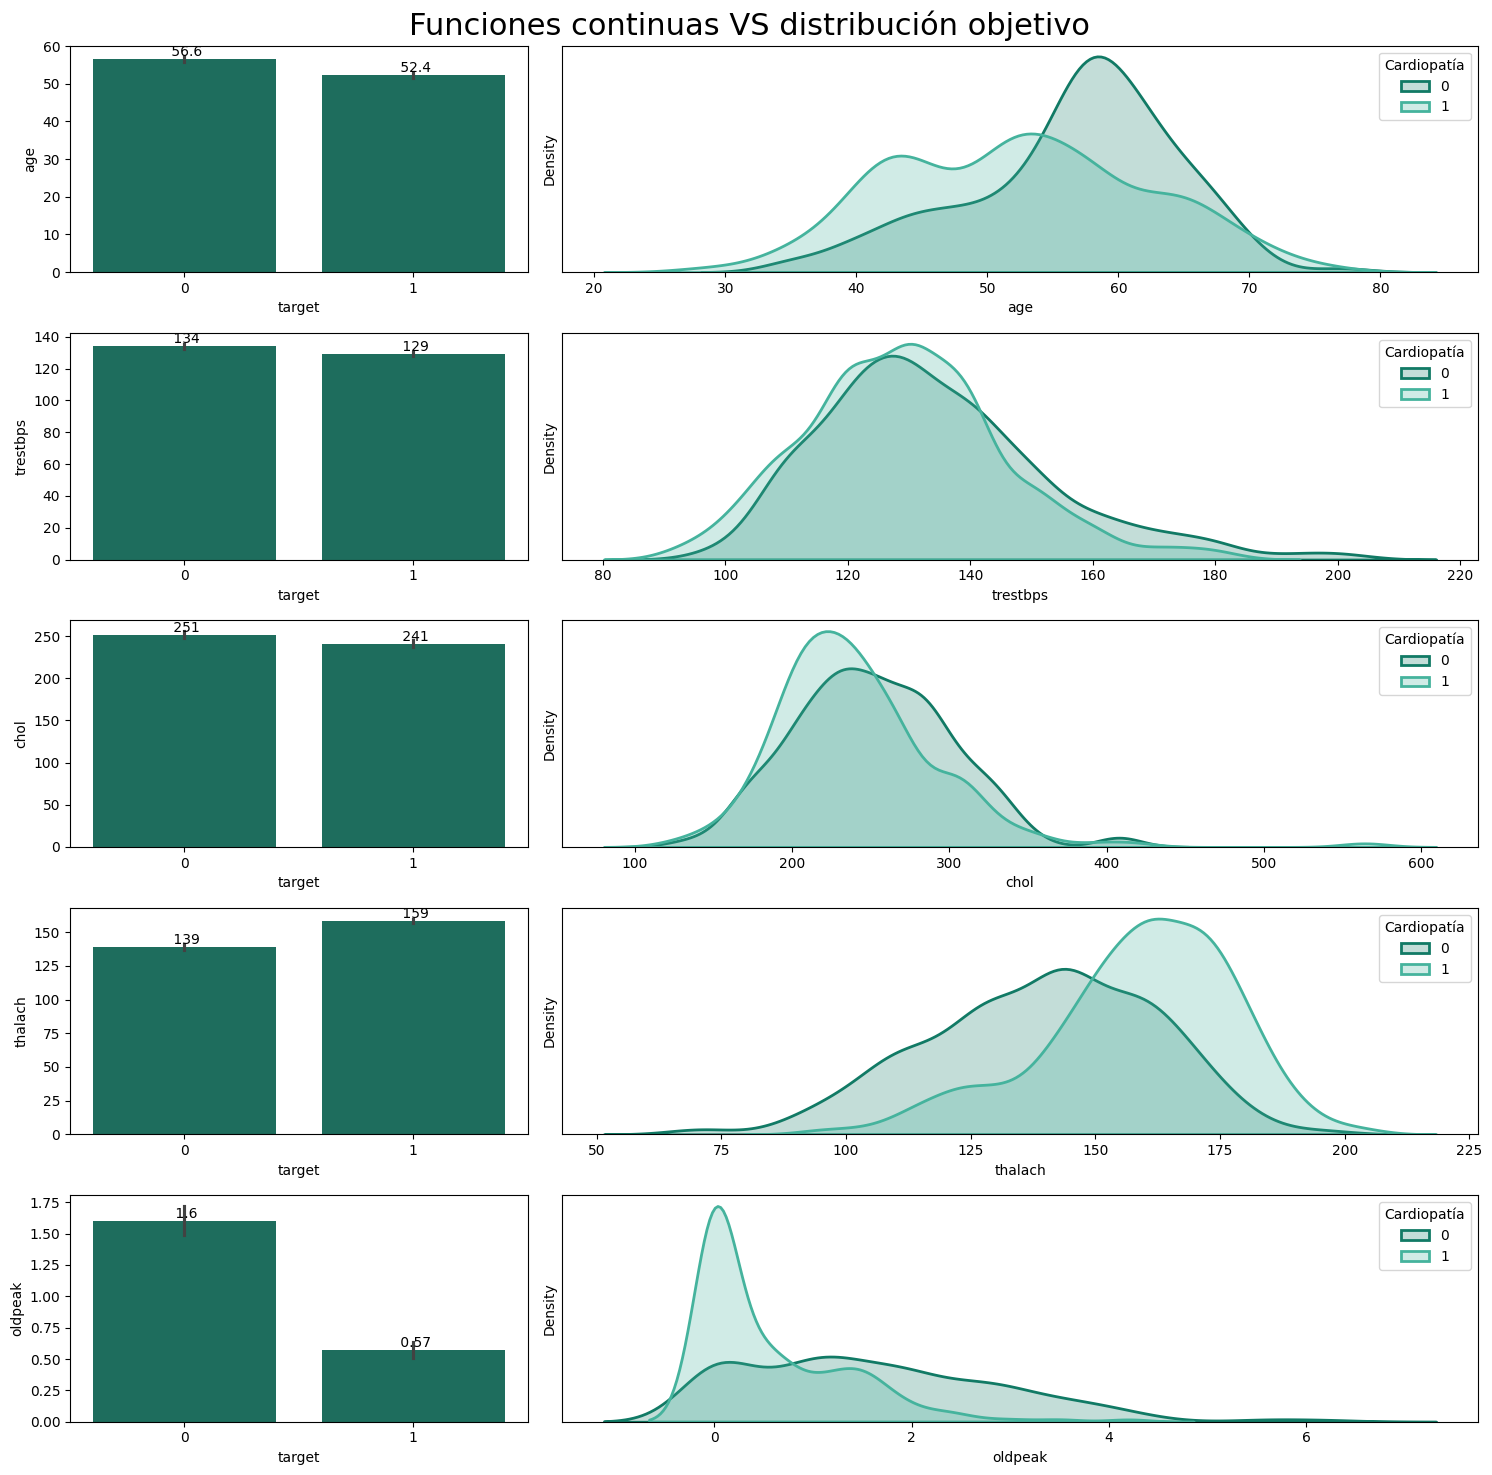

In [9]:
sns.set_palette(["#117A65", "#45B39D"])

fig, ax = plt.subplots(
    len(continuous_features), 2, figsize=(15, 15), gridspec_kw={"width_ratios": [1, 2]}
)

for i, col in enumerate(continuous_features):
    graph = sns.barplot(data=df, x="target", y=col, ax=ax[i, 0])

    sns.kdeplot(
        data=df[df["target"] == 0],
        x=col,
        fill=True,
        linewidth=2,
        ax=ax[i, 1],
        label="0",
    )
    sns.kdeplot(
        data=df[df["target"] == 1],
        x=col,
        fill=True,
        linewidth=2,
        ax=ax[i, 1],
        label="1",
    )
    ax[i, 1].set_yticks([])
    ax[i, 1].legend(title="Cardiopatía", loc="upper right")

    for cont in graph.containers:
        graph.bar_label(cont, fmt=" %.3g")

plt.suptitle("Funciones continuas VS distribución objetivo", fontsize=22)
plt.tight_layout()
plt.show()

+ _***Edad***_ `age`: Las distribuciones muestran un ligero cambio, siendo los pacientes con enfermedades cardíacas un poco más jóvenes en promedio que los que no las padecen. La edad media de los pacientes sin enfermedades cardíacas es mayor.

+ _***Presión arterial en reposo***_ `trestbps`: Ambas categorías muestran distribuciones superpuestas en el gráfico de KDE, con valores medios casi idénticos, lo que indica un poder diferenciador limitado para esta característica.

+ _***Colesterol sérico***_ `chol`: Las distribuciones de los niveles de colesterol para ambas categorías son bastante cercanas, pero el nivel medio de colesterol para pacientes con enfermedades cardíacas es ligeramente menor.

+ _***Frecuencia cardíaca máxima alcanzada***_ `thalach`: hay una diferencia notable en las distribuciones. Los pacientes con enfermedades cardíacas tienden a alcanzar una frecuencia cardíaca máxima más alta durante las pruebas de esfuerzo en comparación con aquellos que no la padecen.

+ _***Depresión del ST***_ `oldpeak`: la depresión del ST inducida por el ejercicio en relación con el reposo es notablemente menor en pacientes con enfermedades cardíacas. Su distribución alcanza un máximo cercano a cero, mientras que la categoría de no enfermedad tiene una distribución más amplia.

Según la diferencia visual en las distribuciones y los valores medios, la frecuencia cardíaca máxima `thalach` parece tener el mayor impacto en el estado de la enfermedad cardíaca, seguida de la depresión del ST `oldpeak` y la edad `age`.

## 3. PREPROCESAMIENTO DE DATOS.

Todas las características del conjunto de datos parecen ser relevantes. Ninguna columna parece redundante o irrelevante. Por lo tanto, conservaremos todas las funciones, asegurando que no se pierda información valiosa.

In [10]:
df.isnull().sum().sum()

np.int64(0)

Ejecutando el metodo `isnull` se puede observar que no faltan valores en nuestro conjunto de datos. Esto es ideal, ya que significa que no tenemos que tomar decisiones sobre la imputación o eliminación.

Se buscaran valores atípicos usando el método `IQR` para las características continuas:

In [11]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [12]:
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_features] < (Q1 - 1.5 * IQR)) | (df[continuous_features] > (Q3 + 1.5 * IQR))).sum()

outliers_count_specified

age          0
trestbps    30
chol        16
thalach      4
oldpeak      7
dtype: int64

Al identificar valores atípicos para las características continuas especificadas, encontramos lo siguiente:

`trestbps`: 30 valores atípicos

`chol`: 16 valores atípicos

`thalach`: 4 valor atípico

`oldpeak`: 5 valores atípicos

`age`: Sin valores atípicos

_***Sensibilidad a valores atípicos:***_ SVM (máquina de vectores de soporte): Las SVM pueden ser sensibles a valores atípicos. Si bien el límite de decisión está determinado principalmente por los vectores de soporte, los valores atípicos pueden influir en qué puntos de datos se eligen como vectores de soporte, lo que podría conducir a una clasificación subóptima.

_***Árboles de decisión (DT)***_: Los árboles de decisión generalmente son resistentes a los valores atípicos. Realizan divisiones basadas en valores de características y los valores atípicos a menudo terminan en nodos de hoja, lo que tiene un impacto mínimo en el proceso general de toma de decisiones.

_***K-Vecinos más cercanos (KNN)***_: KNN es sensible a los valores atípicos porque se basa en las distancias entre puntos de datos para hacer predicciones. Los valores atípicos pueden distorsionar estas distancias.

Enfoques para el tratamiento de valores atípicos:

+ _***Eliminación de valores atípicos:***_ Descartar directamente los puntos de datos que queden fuera de un rango definido, generalmente según un método como el rango intercuartil (IQR).

+ _***Limitar los valores atípicos:***_ En lugar de eliminarlos, podemos limitar los valores atípicos a un umbral determinado, como el percentil 1 o 99.

_***Transformaciones:***_ La aplicación de transformaciones como log o Box-Cox puede reducir el impacto de los valores atípicos y hacer que los datos sean más gaussianos.

_***Escalado robusto:***_ Se pueden utilizar técnicas como RobustScaler en Scikit-learn, que escala características utilizando estadísticas que son robustas frente a valores atípicos.

`Conclusión:`
Dada la naturaleza de los algoritmos (especialmente SVM y KNN) la eliminación directa de valores atípicos podría no ser el mejor enfoque. En cambio, nos centraremos en aplicar transformaciones como Box-Cox en los pasos siguientes para reducir el impacto de los valores atípicos y hacer que los datos sean más adecuados para el modelado.

_***Codificación de características categóricas:***_

A continuacion se implementara la codificacion `one-hot` para tratar los datos

+ `sex`: Esta es una variable binaria con dos categorías (masculino y femenino), por lo que no necesita codificación one-hot.

`cp`: El tipo de dolor torácico puede considerarse nominal porque no existe una relación ordinal clara entre los diferentes tipos de dolor torácico (como angina típica, angina atípica, etc.). debe tener codificacion one-hot.

`fbs`: Esta es una variable binaria (verdadera o falsa), por lo que no necesita codificación one-hot.

`restecg`: Esta variable representa los resultados electrocardiográficos en reposo. Los resultados, como "Normal", "Tener anomalía de la onda ST-T" y "Mostrar hipertrofia ventricular izquierda probable o definitiva", no parecen tener una relación ordinal. Por lo tanto, debe tener codificacion one-hot.

`exang`: Esta es una variable binaria (sí o no), por lo que no necesita codificación one-hot.

`slope`: Representa la pendiente del segmento ST del ejercicio máximo. Dadas las descripciones (Ascendente, Plano, Descendente), parece tener una naturaleza ordinal, sugiriendo un orden particular. Por lo tanto, no es necesaria la codificacion one-hot.

`ca`: Representa el número de vasos principales coloreados mediante fluoroscopia. Como indica un conteo, tiene una relación ordinal inherente. Por lo tanto, no es necesaria la codificacion one-hot.

`thal`: Esta variable representa el resultado de una prueba de estrés con talio. Los diferentes estados, como "Normal", "Defecto reparado" y "Defecto reversible", sugieren una naturaleza nominal. Por lo tanto, debe tener codificacion one-hot.

Para implementar la codificacion _***One-Hot***_ se siguen los siguientes pasos:

+ Se crea una variable ficticia `df_encoded` utilizando el metodo de _***pandas***_ `get_dummies` estas variables serviran para hacer la codificacion _***One-Hot***_ en las variables que la requieren.

+ Se crea otra variable `feature_to_convert` la cual contendra las variables que no necesitan codificacion _***One-Hot***_.

+ Se itera la serie de datos `feature_to_convert` para convertir los datos que necesitan la codificacion _***One-Hot***_ a tipo de dato _***int***_

In [13]:
df_encoded = pd.get_dummies(df, columns=["cp", "restecg", "thal"], drop_first=True)
features_to_convert = ["sex", "fbs", "exang", "slope", "ca", "target"]
for feature in features_to_convert:
    df_encoded[feature] = df_encoded[feature].astype(int)

df_encoded.dtypes

age            int64
sex            int64
trestbps       int64
chol           int64
fbs            int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
target         int64
cp_1            bool
cp_2            bool
cp_3            bool
restecg_1       bool
restecg_2       bool
thal_1          bool
thal_2          bool
thal_3          bool
dtype: object

In [14]:
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,52,1,125,212,0,168,0,1.0,2,2,0,False,False,False,True,False,False,False,True
1,53,1,140,203,1,155,1,3.1,0,0,0,False,False,False,False,False,False,False,True
2,70,1,145,174,0,125,1,2.6,0,0,0,False,False,False,True,False,False,False,True
3,61,1,148,203,0,161,0,0.0,2,1,0,False,False,False,True,False,False,False,True
4,62,0,138,294,1,106,0,1.9,1,3,0,False,False,False,True,False,False,True,False


El escalado de características es un paso de preprocesamiento crucial para algoritmos que son sensibles a la magnitud o escala de las características.

Modelos como SVM, KNN y muchos modelos lineales se basan en distancias o gradientes, lo que los hace susceptibles a variaciones en las escalas de características. El escalado garantiza que todas las características contribuyan por igual a la decisión del modelo en lugar de estar dominadas por características con magnitudes mayores.

El escalado de funciones es vital para algunos modelos, no todos los algoritmos requieren datos escalados. En este preprocesamiento de datos se manejara el escalamiento mediante canalizaciones. Este enfoque nos permite aplicar el escalado específicamente para los modelos que se benefician de él, asegurando flexibilidad y eficiencia en nuestro proceso de modelado.

#### _***Transformación de funciones sesgadas y preocupaciones sobre fuga de datos***_.

Al preprocesar los datos, especialmente al aplicar transformaciones como Box-Cox, es esencial tener cuidado con la fuga de datos. Esto puede conducir a métricas de rendimiento demasiado optimistas.

Para evitar la fuga de datos y garantizar que nuestro modelo se generalice bien a datos invisibles se hace lo siguiente:

+ `División de datos:` primero se divide el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba. Esto garantiza que tengamos un conjunto de datos separado para evaluar el rendimiento de nuestro modelo.

+ `Transformación Box-Cox:` se examinara la distribución de las características continuas en el conjunto de entrenamiento. Si parecen sesgados, aplicaremos la transformación Box-Cox para estabilizar la varianza y hacer que los datos se parezcan más a una distribución normal. Es importante destacar que determinaremos los parámetros de transformación Box-Cox únicamente en función de los datos de entrenamiento.

+ `Aplicación de transformaciones a los datos de prueba:` una vez que los parámetros de transformación se determinen a partir del conjunto de entrenamiento, usaremos estos parámetros exactos para transformar nuestro conjunto de datos de prueba. Este enfoque garantiza que ninguna información del conjunto de datos de prueba se filtre en nuestro proceso de capacitación.

+ `Ajuste de hiperparámetros y validación cruzada:` Se empleara la validación cruzada en el conjunto de entrenamiento para el ajuste de hiperparámetros. Esto permite tener una mejor idea de cómo podría funcionar nuestro modelo con datos invisibles, sin necesidad de utilizar el conjunto de prueba. El conjunto de prueba permanece intacto durante esta fase y solo se utiliza para evaluar el rendimiento del modelo final.

Al seguir este enfoque estructurado, se garantiza un proceso de capacitación riguroso, minimizamos el riesgo de fuga de datos y nos preparamos para obtener una medida realista del rendimiento de nuestro modelo en datos invisibles.

Para entrenar el modelo de datos se hace lo siguiente:

+ Se define la variable dependiente `X` a la cual se le asigna la serie de datos de la variable _***df_encoded***_ sin el campo de datos _***target***_.

+ Se define la variable independiente `Y` a la cual se la asigna el campo `target` de la serie de datos df_encoded.

+ Se dividen los datos del conjunto entre datos de entrenamiento y datos de prueba, asignando al modulo de prueba un 20% de los datos y un 80% de los datos al modulo de entrenamiento.

In [15]:
X = df_encoded.drop('target', axis=1)
y = df_encoded['target'] 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [17]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

La transformación Box-Cox requiere que todos los datos sean estrictamente positivos. 
Para transformar la característica oldpeak usando Box-Cox, podemos agregar una pequeña constante (por ejemplo, 0,001) para garantizar que todos los valores sean positivos:

In [18]:
X_train['oldpeak'] = X_train['oldpeak'] + 0.001
X_test['oldpeak'] = X_test['oldpeak'] + 0.001

En la siguiente visualizacion de datos se comprobara la distribucion de las caracteristicas continuas para ver como es el comportamineto de los datos en el modelo, para eso se hace  lo siguiente:

+ Se crea un ciclo _***for***_ que iterara y creara gráficos de histogramas para cada columna de la serie de datos alojada en la variable `continuous_features`, mostrando la distribución de los valores en cada columna.
+ Se crea un diccionario que almacenara que almacenara los valores de cada caracteristica.
+ Se crea un ciclo _***for***_ el cual servira para hacer las transformaciones de datos Box-Cox
    + La transformación _***Box-Cox***_ es una técnica utilizada para estabilizar la varianza y hacer que los datos se asemejen más a una distribución normal.
    + Se aplica solo a las columnas con valores positivos `(X_train[col].min() > 0)`.
    + La transformación _***Box-Cox***_ se calcula utilizando la función `boxcox` de la libreria `SciPy`. Esta función encuentra el valor óptimo de `lambda` (parámetro de la transformación) que maximiza la normalidad de los datos.
    + Los datos de entrenamiento `X_train` se transforman y se almacena el valor de `lambda` en el diccionario _***lambdas***_.

Luego, se aplica la misma transformación a los datos de prueba `X_test`.

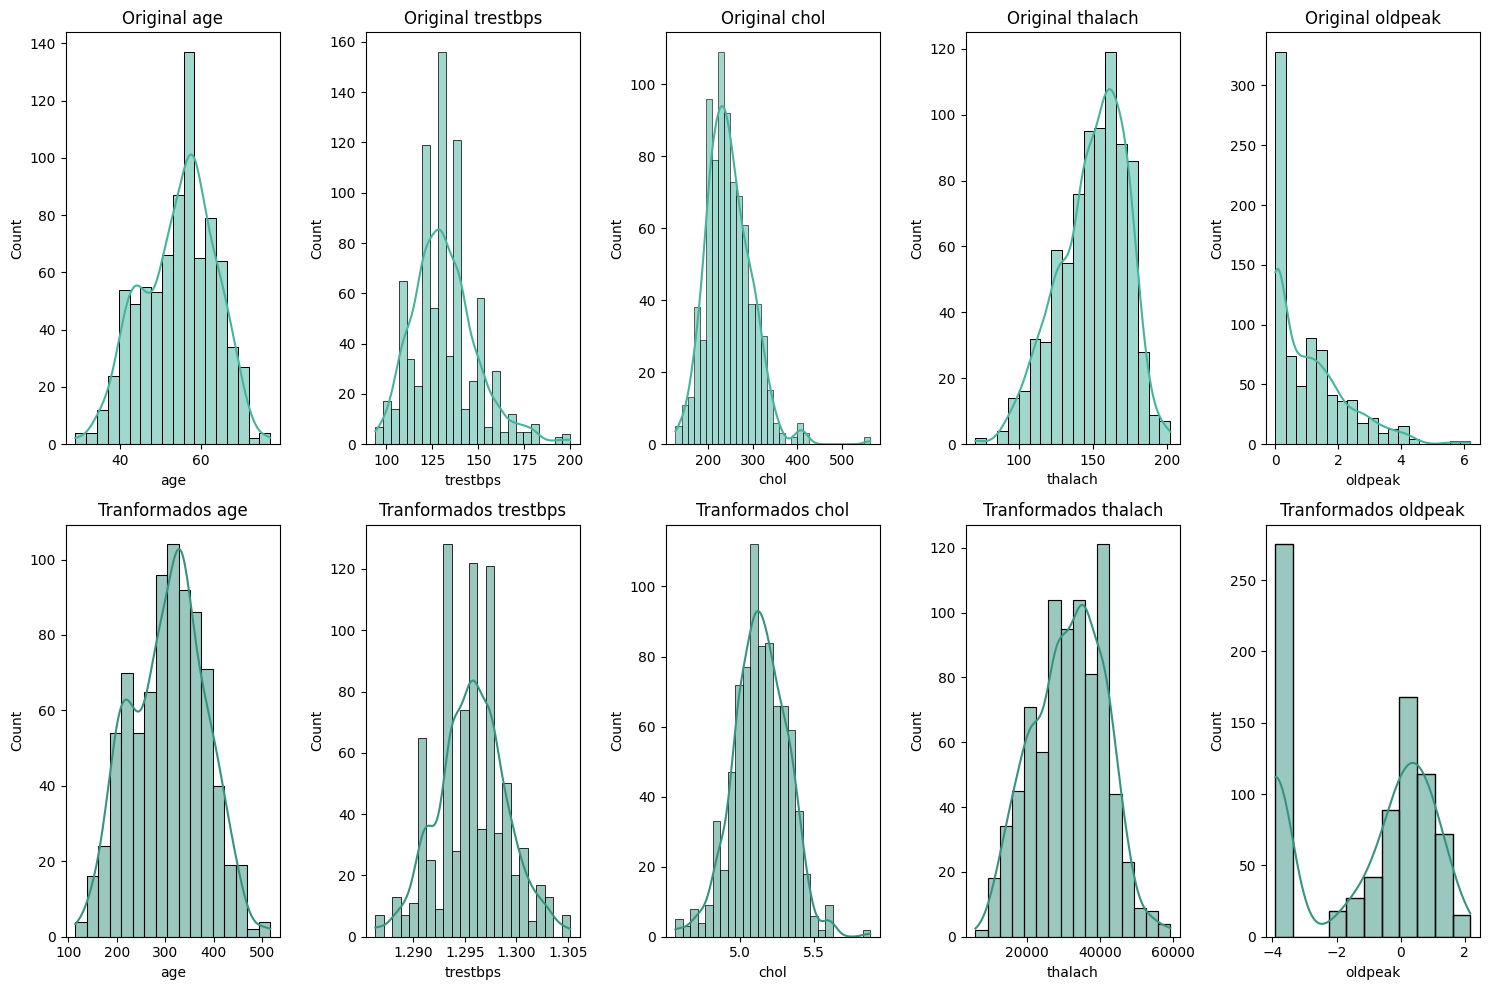

In [19]:
fig, ax = plt.subplots(2, 5, figsize=(15,10))
for i, col in enumerate(continuous_features):
    sns.histplot(X_train[col], kde=True, ax=ax[0,i], color='#45B39D').set_title(f'Original {col}')
lambdas = {}
for i, col in enumerate(continuous_features):
    if X_train[col].min() > 0:
        X_train[col], lambdas[col] = boxcox(X_train[col])
        X_test[col] = boxcox(X_test[col], lmbda=lambdas[col]) 
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='#369380').set_title(f'Tranformados {col}')
    else:
        sns.histplot(X_train[col], kde=True, ax=ax[1,i], color='#369380').set_title(f'{col} (No Transformados)')
fig.tight_layout()
plt.show()

+ _***Edad***_ `age`: La transformación ha hecho que la distribución de edades sea más simétrica, acercándola a una distribución normal.

+ _***Presión arterial en reposo***_ `Trestbps:` la distribución de trestbps después de la transformación parece ser más normal, con una asimetría reducida.

+ _***Colesterol sérico***_ `Chol:` Después de aplicar la transformación Box-Cox, el chol exhibe una forma más alineada con una distribución normal.

+ _***Frecuencia cardíaca máxima alcanzada durante una prueba de esfuerzo***_ `Thalach:` La característica del thalach ya era bastante simétrica antes de la transformación y, después de la transformación, continúa mostrando una forma similar, lo que indica que su distribución original era cercana a la normal.

+ _***Depresión del ST inducida por el ejercicio en relación con el reposo***_ `Oldpeak:` La transformación _***box-cox***_ mejoró la distribución oldpeak, pero aún no se parece perfectamente a una distribución normal. Esto podría deberse a la naturaleza inherente de los datos o a la presencia de valores atípicos.

_***Conclusión:***_

Transformar las características para que sean más normales ayuda principalmente a mitigar el impacto de los valores atípicos, lo que es particularmente beneficioso para los algoritmos basados ​​en la distancia como _***SVM***_ y _***KNN***_. Al reducir la influencia de los valores atípicos, nos aseguramos de que estos algoritmos puedan calcular distancias de manera más efectiva y producir resultados más confiables.

In [20]:
X_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
397,188.243855,1,1.291178,4.818109,0,16654.592901,1,0.739965,1,0,False,False,False,False,False,False,False,True
687,333.780046,1,1.294735,5.333015,0,40983.789741,0,-3.905686,2,2,False,False,False,False,False,False,False,True
909,265.549656,1,1.298293,4.977380,0,20800.169014,1,-0.103254,1,0,False,False,False,False,False,False,False,True
153,298.985468,1,1.293636,5.201129,0,29291.926122,0,-0.840949,1,0,False,True,False,False,False,False,False,True
373,333.780046,1,1.293636,5.285143,0,35357.536287,0,0.621445,1,0,True,False,False,False,False,False,True,False


## MACHINE LEARNING

### 4.1 Construcción del modelo de árbol de decisión

Se define el modelo de arbol de decisión

In [21]:
dt_base = DecisionTreeClassifier(random_state=0)

_***Ajuste de hiperparámetros***_

se desarrollara una función para determinar el conjunto óptimo de hiperparámetros que produzcan el mayor recuento de datos para el modelo. Este enfoque garantiza un marco reutilizable para el ajuste de hiperparámetros de modelos posteriores.

Esta función Utilizara `GridSearchCV` que prueba diferentes combinaciones de valores para los hiperparámetros del modelo y evalua su rendimiento y su validación cruzada, es importante que cada pliegue conserve la proporción de muestras para cada clase. `StratifiedKFold` garantiza que esto suceda al dividir los datos de manera estratificada, es decir, manteniendo la distribución de clases en cada pliegue. La combinación con el mayor retiro para la clase 1 se selecciona como métrica de puntuación predeterminada. La función devuelve el clasificador con los hiperparámetros óptimos.

En una validación cruzada estándar de K veces, el conjunto de datos se divide en K subconjuntos (o pliegues) y el modelo se entrena y evalúa K veces, cada vez utilizando un pliegue diferente como conjunto de validación y los pliegues restantes como conjunto de entrenamiento.

Sin embargo, en las tareas de clasificación, es importante garantizar que cada pliegue conserve la proporción de muestras para cada clase. Aquí es donde entra en juego el `muestreo estratificado`.

_***Estratificación***_: antes de dividir los datos en pliegues, El metodo de validacion cruzada `StratifiedKFold` divide el conjunto de datos de modo que cada pliegue tenga aproximadamente la misma proporción de muestras de cada clase que todo el conjunto de datos.

_***División en K pliegues***_: después de la estratificación, el conjunto de datos se divide en K pliegues, manteniendo la distribución de clases en cada pliegue.

_***Capacitación y evaluación***_: durante cada iteración que hace `StratifiedKFold` (Validacion cruzada), se usa un pliegue para la validación y los pliegues restantes se usan para el entrenamiento.

Al utilizar el muestreo estratificado, `StratifiedKFold` garantiza que las estimaciones de rendimiento del modelo sean más representativas, especialmente cuando se trata de conjuntos de datos desequilibrados donde una clase puede ser significativamente menos frecuente que las demás. Ayuda a mitigar el riesgo de sobreajuste o estimaciones de rendimiento sesgadas que pueden ocurrir con el muestreo aleatorio simple en la validación cruzada.

Para desarrollar la funcion se siguen los siguientes pasos:

+  Se Crea una variable `cv` en la cual se creara el objeto de validación cruzada utilizando `StratifiedKFold` para garantizar que la distribución de clases sea la misma en todos los pliegues.
+ Se crea otra variable _***clf_grid***_ la cual servira para hacer una búsqueda exhaustiva que evalúa diferentes combinaciones de hiperparámetros en el modelo y esta prueba todas las combinaciones posibles de hiperparámetros para seleccionar la mejor según la métrica de puntuación especificada y asi poder hacer el entrenamiento de los datos que serviran para hacer las predicciones del modelo.
+ Con el metodo `fit` se entrena el modelo para poder hacer las predicciones de las enfermedades cardiacacas.

In [22]:
def tune_clf_hyperparameters(
    clf, param_grid, X_train, y_train, scoring="recall", n_splits=3):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    clf_grid.fit(X_train, y_train)

    best_hyperparameters = clf_grid.best_params_
    return clf_grid.best_estimator_, best_hyperparameters

Se configura la cuadrícula de hiperparámetros y se utiliza la función _***tune_clf_hyperparameters***_ creada anteriormente para identificar los hiperparámetros óptimos para nuestro modelo

In [23]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2]
}

Se llama la función `tune_clf_hyperparameters` para el ajuste de hiperparámetros

In [24]:
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)
print('Hiperparámetros óptimos del modelo DT: \n', best_dt_hyperparams)

Hiperparámetros óptimos del modelo DT: 
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


Ahora se evaluara el rendimiento del `modelo DT` tanto en el conjunto de datos de entrenamiento como en el conjunto de datos de prueba

In [25]:
print(classification_report(y_train, best_dt.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       399
           1       0.84      0.85      0.85       421

    accuracy                           0.84       820
   macro avg       0.84      0.84      0.84       820
weighted avg       0.84      0.84      0.84       820



In [26]:
print(classification_report(y_test, best_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       100
           1       0.87      0.90      0.88       105

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205



Dado que los valores de las métricas para los conjuntos de datos de entrenamiento y de prueba están estrechamente alineados y no son significativamente diferentes, el modelo no parece estar sobreajustado.

A continuacion se creara una función que consolide las métricas de cada modelo en un marco de datos, facilitando una comparación de un extremo a otro de todos los modelos más adelante.

para desarrollar la funcion se hace lo siguiente:

+ Se crea una variable `y_pred` a la cual se le asigna el metodo `predict` que servira para predecir los datos de prueba `x_test`
+ Se crea una variable `report` la cual servira para obtener el reporte de clasificacion que es una descripción detallada de las métricas de clasificación para cada clase en un conjunto de datos.
+ Se crea un diccionario `metrics` el cual alojara las metricas que seran usadas en los modelos posteriores.
+ Se crea una variable `df` en la cual se usara el metodo `pd.DataFrame` el cual servira para convertir el diccionario en un DataFrame para poder manipular los datos.

In [27]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics = {
        "precision_0": report["0"]["precision"],
        "precision_1": report["1"]["precision"],
        "recall_0": report["0"]["recall"],
        "recall_1": report["1"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "f1_1": report["1"]["f1-score"],
        "macro_avg_precision": report["macro avg"]["precision"],
        "macro_avg_recall": report["macro avg"]["recall"],
        "macro_avg_f1": report["macro avg"]["f1-score"],
        "accuracy": accuracy_score(y_test, y_pred)
    }
    df = pd.DataFrame(metrics, index=[model_name]).round(2)
    
    return df

A continuacion se evalua el modelo usando el metodo `evaluate_model` que calculara los resultados de las metricas de precisión

In [28]:
dt_evaluation = evaluate_model(best_dt, X_test, y_test, 'Modelo de Arbol de decision')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
Modelo de Arbol de decision,0.89,0.87,0.86,0.9,0.87,0.88,0.88,0.88,0.88,0.88


### 4.2 Construcción del modelo KNN

Se define el modelo KNN y se configura el pipeline con escaler

In [29]:
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

Se configura la cuadrícula de los hiperparametros utilizando la función _***Tune_CLF_HyperParameters***_ para determinar los hiperparámetros óptimos para el modelo KNN:

In [30]:
knn_param_grid = {
    'knn__n_neighbors': list(range(1, 12)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

In [31]:
best_knn, best_knn_hyperparams = tune_clf_hyperparameters(knn_pipeline, knn_param_grid, X_train, y_train)
print('Hiperparámetros óptimos del modelo KNN: \n', best_knn_hyperparams)

Hiperparámetros óptimos del modelo KNN: 
 {'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'}


Se evalua el rendimiento del modelo en los conjuntos de datos de entrenamiento y el conjunto de datos de prueba:

In [32]:
print(classification_report(y_train, best_knn.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       399
           1       1.00      1.00      1.00       421

    accuracy                           1.00       820
   macro avg       1.00      1.00      1.00       820
weighted avg       1.00      1.00      1.00       820



In [33]:
print(classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



Los puntajes consistentes del modelo KNN en los conjuntos de entrenamiento y prueba indican que no hay un sobreajuste.

In [34]:
knn_evaluation = evaluate_model(best_knn, X_test, y_test, 'Modelo KNN')
knn_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
Modelo KNN,0.97,1.0,1.0,0.97,0.99,0.99,0.99,0.99,0.99,0.99


### _***4.3 Construccion del modelo SVM***_

Se define el modelo SVM

In [35]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True)) 
])

Se configura la cuadrícula de hiperparámetros y se emplea la función _***tune_clf_hyperparameters***_ para determinar los mejores hiperparámetros para el modelo SVM

In [36]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}

In [37]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],  
    'svm__degree': [2, 3, 4]
}
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, X_train, y_train)
print('Hiperparámetros óptimos del modelo SVM: \n', best_svm_hyperparams)

Hiperparámetros óptimos del modelo SVM: 
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


Se muestra el rendimiento de nuestro modelo SVM en los conjuntos de datos de entrenamiento y el conjunto de datos de  prueba

In [38]:
print(classification_report(y_train, best_svm.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       399
           1       0.51      1.00      0.68       421

    accuracy                           0.51       820
   macro avg       0.26      0.50      0.34       820
weighted avg       0.26      0.51      0.35       820



In [39]:
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.51      1.00      0.68       105

    accuracy                           0.51       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.26      0.51      0.35       205



En general, el rendimiento del modelo es prometedor para el diagnóstico médico, especialmente cuando prioriza la identificación precisa de los pacientes con enfermedad cardíaca sin sobrecargar el sistema con falsas alarmas.

In [40]:
svm_evaluation = evaluate_model(best_svm, X_test, y_test, 'Modelo SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
Modelo SVM,0.0,0.51,0.0,1.0,0.0,0.68,0.26,0.5,0.34,0.51


## 5. Concluciones
En el contexto crítico del diagnóstico de enfermedades cardíacas, Es necesario identificar con precisión cada caso potencial de enfermedad cardíaca, ya que incluso un diagnóstico omitido podría tener implicaciones nefastas. Es esencial mantener un rendimiento equilibrado para evitar intervenciones médicas innecesarias en personas sanas. 

A continuacion evaluaremos los modelos creados anteriormente y se compararan para saber cual fue el mejor.
Para esto seguimos los siguientes pasos:

+ Se crea una variable `all_evaluation` en la cual se concatenaran los resultados de los 3 modelos creados
+ Se crea otra variable `result` a la cual se le asigna el método `sort_values` el cual ordenara los resultados de las predicciones de los modelos de forma ascendente 

In [41]:
all_evaluations = [dt_evaluation, knn_evaluation, svm_evaluation]
results = pd.concat(all_evaluations)
results = results.sort_values(by='recall_1', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
Modelo SVM,0.00,0.51,0.00,1.00,0.00,0.68,0.26,0.50,0.34,0.51
Modelo KNN,0.97,1.00,1.00,0.97,0.99,0.99,0.99,0.99,0.99,0.99
Modelo de Arbol de decision,0.89,0.87,0.86,0.90,0.87,0.88,0.88,0.88,0.88,0.88


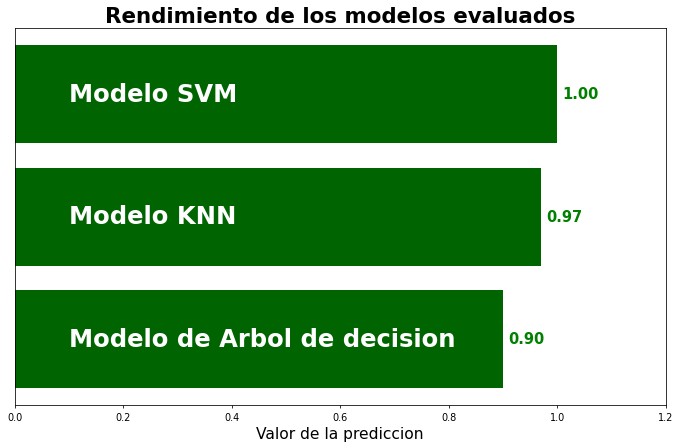

In [42]:
results.sort_values(by='recall_1', ascending=True, inplace=True)
recall_1_scores = results['recall_1']
fig, ax = plt.subplots(figsize=(12, 7), dpi=70)
ax.barh(results.index, recall_1_scores, color='darkgreen')

for i, (value, name) in enumerate(zip(recall_1_scores, results.index)):
    ax.text(value + 0.01, i, f"{value:.2f}", ha='left', va='center', fontweight='bold', color='green', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=25)

ax.set_yticks([])

ax.set_xlim([0, 1.2])

plt.title("Rendimiento de los modelos evaluados", fontweight='bold', fontsize=22)
plt.xlabel('Valor de la prediccion', fontsize=16)
plt.show()